# XGBoost for Airline Time Series

In [1]:
from xgboost import XGBRegressor
from sktime.datasets import load_airline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

/home/nick/apps/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Load of dataset for XGBoost
df = load_airline()
df = df.reset_index()
names = ['Period', 'Number of airline passengers']
new_names = ['period', 'number']
# Renaming the columns of the dataset
df = df.rename(columns={names[0]:new_names[0], names[1]:new_names[1]})
df.period = df.period.astype('str')
df.period = pd.to_datetime(df.period, format='%Y-%m')
# Splitting the data to train and validation sets
y_validate = df.iloc[90:]
y = df.iloc[:90]

Text(0, 0.5, 'Number of passengers')

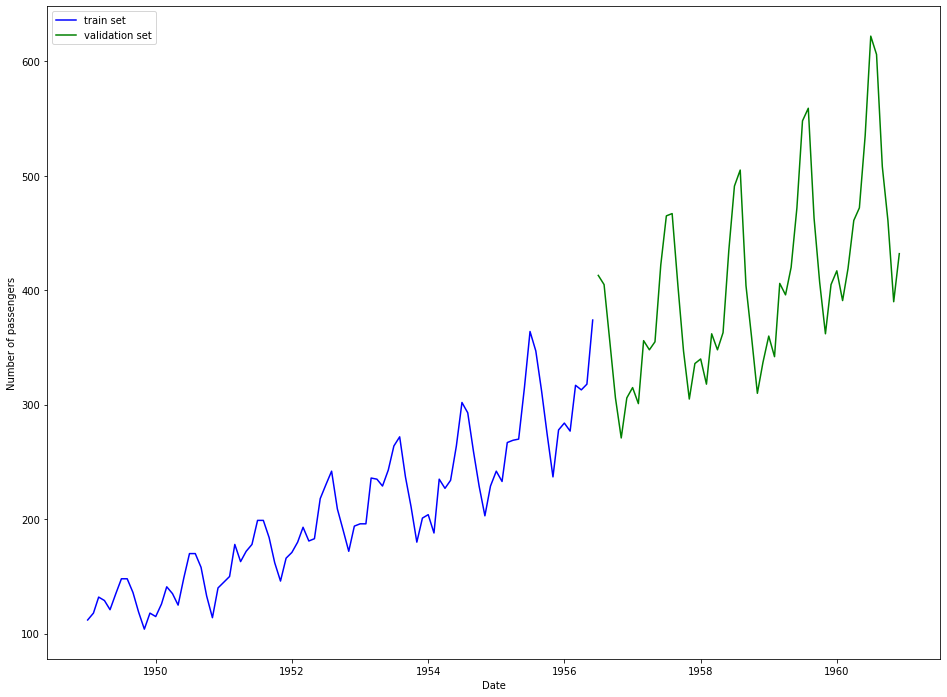

In [3]:
# Visualisation of train and validation datasets
plt.figure(figsize=(16,12))
plt.plot(y.period, y.number, label='train set', c='b')
plt.plot(y_validate.period, y_validate.number, label='validation set', c='g')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of passengers')

In [4]:
# Splitting the data from train dataset into 5 folders for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv = [ (i[0], i[1]) for i in tscv.split(y)]

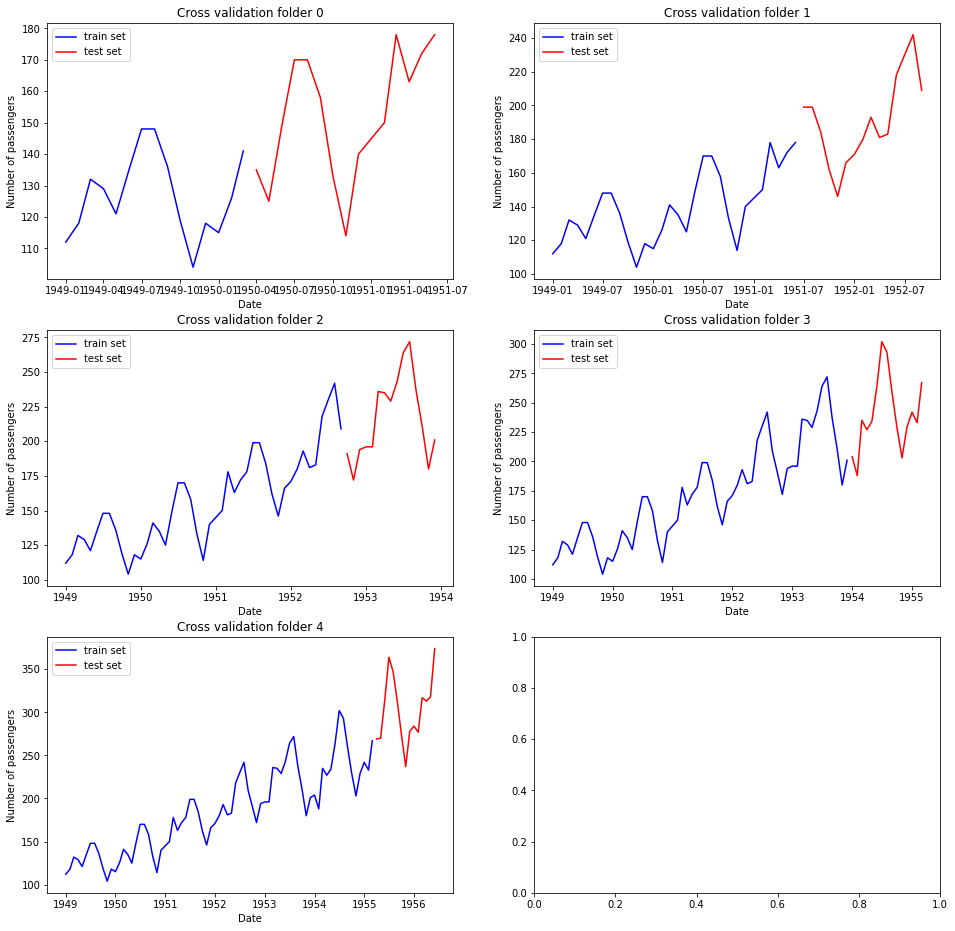

In [5]:
# Visualisation of cross-validation folders
fig, ax = plt.subplots(3,2, figsize=(16,16))
ax = ax.flatten()
for ind, (train, test) in enumerate(cv):
    ax[ind].plot(y.period[train], y.number[train], label='train set', c='b')
    ax[ind].plot(y.period[test], y.number[test], label='test set', c='r')
    ax[ind].set_xlabel('Date')
    ax[ind].set_ylabel('Number of passengers')
    ax[ind].legend()
    ax[ind].set_title('Cross validation folder {0}'.format(ind))

In [6]:
# Function that extracts data variables such as month and year from the date
def change_df(df, num_lag=12, time=True, lag=True):
    names = []
    if time:
        df['month'] = df.period.dt.month
        df['year'] = df.period.dt.year
        names += ['month', 'year'] 
    if lag:
        name_lags = []
        for i in range(1, num_lag):
            name = 'lag_' + str(i)
            name_lags.append(name)
            df[name] = df.number.shift(i)
        names += name_lags
    x = df[names]
    y = df['number']
    return x, y

In order to show perfomance of XGBoost different types of data on which XGBoost was trained:
* data containing only time data
* data containing only lags
* data containing lags and time data

But further in the notebook, will be shown, that even if lag time data was created on real past data and not on predicted past data XGBoost cannot forecast acceptable results.

In [7]:
x_train, y_train = change_df(df, time=True, lag=False)

In [8]:
def prediction(df, pred, test_n, model):
    columns = len(df.columns)
    pred = pred.to_numpy()
    pred = pred[:test_n]
    df[df.index>test_n] = 0
    for i in range(test_n-1, len(df)):
        pred = np.append(pred, model.predict(df[df.index==i]))
        if i < len(df):
            df[df.index==i+1] = pred[-columns-1:-1][::-1]
    return df, pred

In [9]:
def fit_predict(df_train, df_test, num_lags=2, time=True, lag=True, name='Something'):
    df_full = pd.concat((df_train, df_test))
    x_full, y_full = change_df(df_full, num_lags, time, lag)
    x_test, y_test = x_full[x_full.index >= len(df_train)], y_full[y_full.index >= len(df_train)]
    # Extraction of date variables for train set
    X, Y = change_df(y, num_lags, time, lag)
    # Creation of grid to find the best params
    grid = {'n_estimators':[100,500,1000,2000], 'max_depth':[1,2,3,5], 
            'max_leaves':[1,2,5,10], 'n_jobs':[-1]}
    #grid={'max_depth':[1,2,3,5]}
    
    # Creation of GridSearchCV with custom cross validation folders
    # Folders were visualized earlier
    model = GridSearchCV(XGBRegressor(), param_grid=grid, cv=cv, verbose=1, scoring='r2')
    
    # Train of the model on train dataset
    model.fit(X, Y)
    
    # Predicting new values step by step:
    #x_test, y_test = change_df(y_validate, num_lags, time, lag)
    if lag: 
        temp, pred = prediction(x_full, y_full, 90, model)
        pred = pred[91:]
    else:
        pred = model.predict(x_test)
    
    fig,ax = plt.subplots(2,1,figsize=(8,6))
    ax[0].plot(range(len(pred)), pred, c='r', label='Predicted data')
    ax[0].plot(range(len(pred)), y_test, c='b', label='Real data')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Number of passengers')
    ax[0].set_title(name)
    ax[0].legend()
    
    r2_scores = [r2_score(pred[:i], y_test[:i]) for i in range(3, 25)]
    ax[1].plot(range(3,25), r2_scores)
    ax[1].set_xlabel('Month of forecasting')
    ax[1].set_ylabel('$R^2$ score')
    return model, pred

# Prediction using only time data

In [10]:
models = []

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: user 6min 10s, sys: 2.37 s, total: 6min 13s
Wall time: 1min 5s


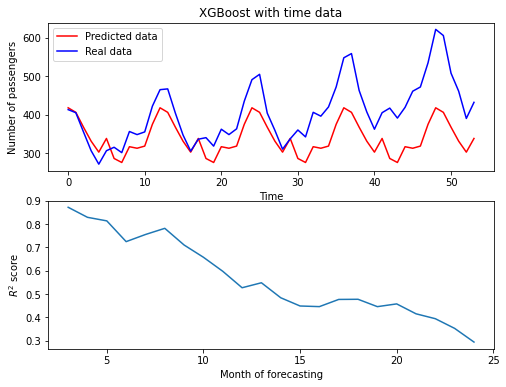

In [11]:
%time models.append(fit_predict(y, y_validate, num_lags=2,time=True, lag=False, name='XGBoost with time data'))

# Prediction using only lags

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: user 6min 33s, sys: 2.24 s, total: 6min 36s
Wall time: 1min 8s


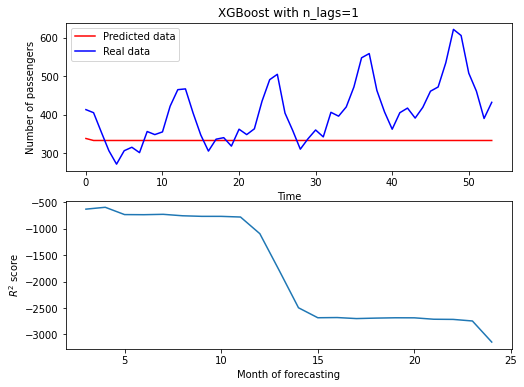

In [12]:
%time models.append(fit_predict(y, y_validate, num_lags=2,time=False, lag=True, name='XGBoost with n_lags=1'))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: user 6min 30s, sys: 2.13 s, total: 6min 32s
Wall time: 1min 6s


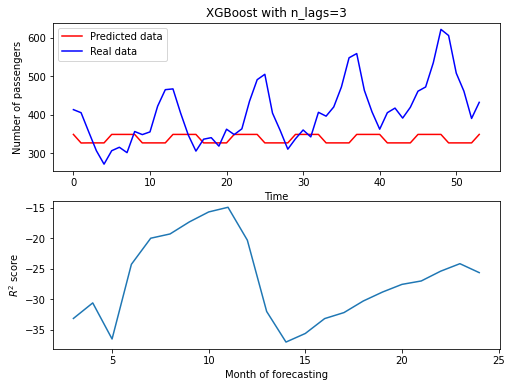

In [13]:
%time models.append(fit_predict(y, y_validate, num_lags=4,time=False, lag=True, name='XGBoost with n_lags=3'))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: user 8min, sys: 2.34 s, total: 8min 3s
Wall time: 1min 18s


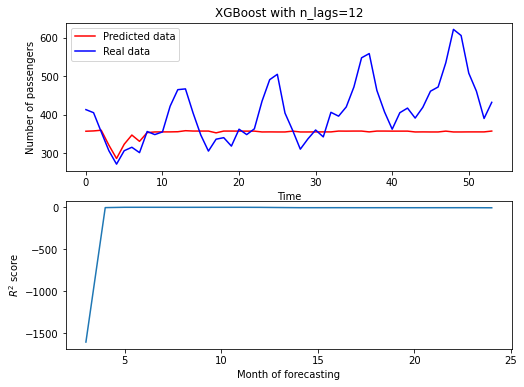

In [14]:
%time models.append(fit_predict(y, y_validate, num_lags=13,time=False, lag=True, name='XGBoost with n_lags=12'))

# Prediction using time and lags data

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: user 7min 57s, sys: 3.16 s, total: 8min 1s
Wall time: 1min 22s


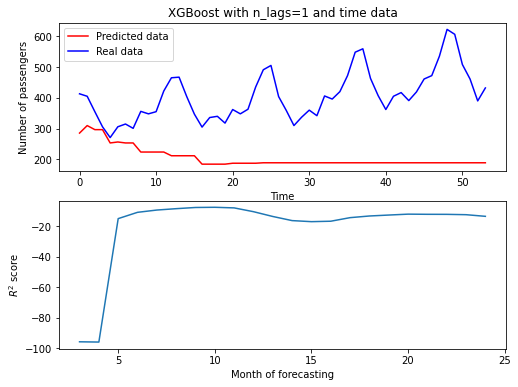

In [15]:
%time models.append(fit_predict(y, y_validate, num_lags=2,time=True, lag=True, name='XGBoost with n_lags=1 and time data'))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: user 8min 24s, sys: 3.07 s, total: 8min 27s
Wall time: 1min 25s


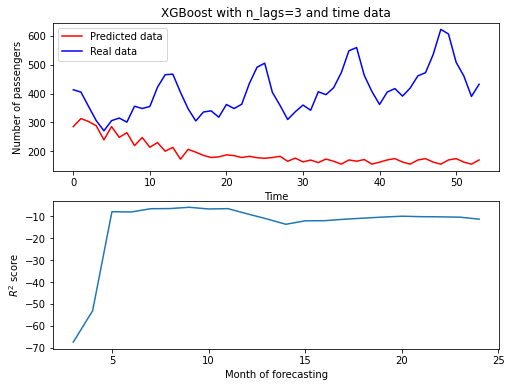

In [16]:
%time models.append(fit_predict(y, y_validate, num_lags=4,time=True, lag=True, name='XGBoost with n_lags=3 and time data'))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: user 7min 38s, sys: 2.02 s, total: 7min 40s
Wall time: 1min 14s


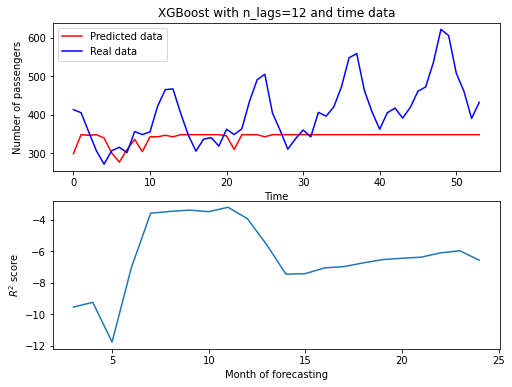

In [17]:
%time models.append(fit_predict(y, y_validate, num_lags=13,time=True, lag=True, name='XGBoost with n_lags=12 and time data'))

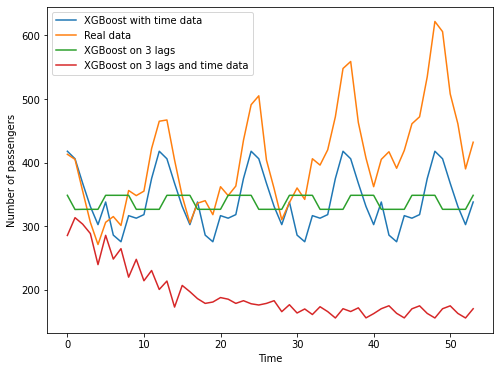

In [18]:
plt.figure(figsize=(8,6))
plt.plot(models[0][1], label='XGBoost with time data')
plt.plot(y_validate.number.to_numpy(), label='Real data')
plt.plot(models[2][1], label='XGBoost on 3 lags')
plt.plot(models[5][1], label='XGBoost on 3 lags and time data')
plt.xlabel('Time')
plt.ylabel('Number of passengers')
plt.legend()

As a result of fitting XGboost with different data we may observe certain dependencies:
* XGBoost trained only on time data can learn seasonality of data, but cannot learn trend of the data.
* XGBoost trained only on lag cannot restore dependencies even when predicting on real values lags.
* XGBoost trained on time and lag datacannot restore dependencies even when predicting on real values lags.